In [ ]:
!pip install transformers pandas torch sentencepiece accelerate

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch
from collections import defaultdict
import re
warnings.filterwarnings('ignore')

# Загрузка данных
df = pd.read_csv('kicksharing.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396749 entries, 0 to 396748
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   order_rk                 396749 non-null  int64  
 1   party_rk                 396749 non-null  int64  
 2   gender_cd                393828 non-null  object 
 3   age                      396749 non-null  int64  
 4   education_level_cd       190059 non-null  object 
 5   marital_status_cd        217729 non-null  object 
 6   lvn_state_nm             362572 non-null  object 
 7   minute_cost              396749 non-null  float64
 8   activation_cost          396749 non-null  float64
 9   hold_amount              396749 non-null  float64
 10  transport_model          396749 non-null  object 
 11  distance_km              396749 non-null  float64
 12  created_dttm             396749 non-null  object 
 13  book_start_dttm          396749 non-null  object 
 14  book

In [ ]:
df.columns

Index(['order_rk', 'party_rk', 'gender_cd', 'age', 'education_level_cd',
       'marital_status_cd', 'lvn_state_nm', 'minute_cost', 'activation_cost',
       'hold_amount', 'transport_model', 'distance_km', 'created_dttm',
       'book_start_dttm', 'book_end_dttm', 'book_time_zone_cd',
       'local_book_start_dttm', 'nominal_price_rub_amt',
       'loyalty_accrual_rub_amt', 'loyalty_accrual_bns_amt'],
      dtype='object')

In [ ]:
df.head(9)

,order_rk,party_rk,gender_cd,age,education_level_cd,marital_status_cd,lvn_state_nm,minute_cost,activation_cost,hold_amount,transport_model,distance_km,created_dttm,book_start_dttm,book_end_dttm,book_time_zone_cd,local_book_start_dttm,nominal_price_rub_amt,loyalty_accrual_rub_amt,loyalty_accrual_bns_amt
0,266071307,761067705,M,40,UGR,DIV,ТЮМЕНСКАЯ ОБЛ,4.99,30.0,300.0,SL,3.690479,2024-08-07 09:47:25.000000,2024-08-07 09:47:29.325252,2024-08-07 10:07:59.339524,5.0,2024-08-07 11:47:29.325252,134.79,19.48,NaN
1,355113920,614049469,F,30,GRD,MAR,РОСТОВСКАЯ ОБЛ,8.49,50.0,300.0,SL,1.114912,2024-10-17 14:57:20.000000,2024-10-17 14:57:24.586000,2024-10-17 15:04:19.419607,3.0,2024-10-17 14:57:24.586000,109.43,40.30,NaN
2,347424551,757583701,M,28,UGR,UNM,СВЕРДЛОВСКАЯ ОБЛ,5.99,30.0,300.0,E,1.515612,2024-09-19 05:31:41.000000,2024-09-19 05:34:59.476000,2024-09-19 05:41:50.164372,5.0,2024-09-19 07:34:59.476000,71.93,10.79,NaN
3,351562959,541367366,M,24,GRD,UNM,Г МОСКВА,8.99,50.0,300.0,SL,0.499411,2024-10-04 16:05:09.000000,2024-10-04 16:05:13.162000,2024-10-04 16:07:31.724918,3.0,2024-10-04 16:05:13.162000,76.97,7.70,NaN
4,258647149,238473615,M,34,NaN,NaN,Г МОСКВА,6.99,50.0,300.0,SL,2.602028,2024-07-10 06:57:40.000000,2024-07-10 06:57:43.017125,2024-07-10 07:07:48.446462,3.0,2024-07-10 06:57:43.017125,126.89,25.38,NaN
5,277397094,5247768,M,42,NaN,NaN,МОСКВА,7.49,50.0,300.0,SL,0.016090,2024-09-10 09:40:18.000000,2024-09-10 09:40:24.036000,2024-09-10 09:41:03.644495,3.0,2024-09-10 09:40:24.036000,0.00,NaN,NaN
6,273528957,801272780,F,19,NaN,NaN,РЕСП ТАТАРСТАН,7.49,30.0,300.0,SL,4.086853,2024-09-03 14:10:29.000000,2024-09-03 14:10:34.524349,2024-09-03 14:21:25.119585,3.0,2024-09-03 14:10:34.524349,112.39,28.00,NaN
7,265062394,866880584,M,38,NaN,NaN,СВЕРДЛОВСКАЯ ОБЛ,5.99,30.0,300.0,E,2.370597,2024-08-03 03:09:35.000000,2024-08-03 03:09:38.493851,2024-08-03 03:18:47.841493,5.0,2024-08-03 05:09:38.493851,89.90,12.99,NaN
8,351562880,762053500,M,19,NaN,NaN,НОВОСИБИРСКАЯ ОБЛ,5.99,30.0,300.0,E,0.101272,2024-10-04 10:45:16.000000,2024-10-04 10:45:20.457000,2024-10-04 10:47:39.863967,7.0,2024-10-04 14:45:20.457000,47.97,4.80,NaN


#**Обработка датасета**
В изначальном датасете наименования местоположения представлены в виде многих синонимов, например, МОСКВА : г МОСКВА, МОСКВА, гор МОСКВА. В связи с этим требуется обработка датасета


In [ ]:
#Вывод уникальных значений
regions = df['lvn_state_nm'].dropna().unique().tolist()
regions

['ТЮМЕНСКАЯ ОБЛ',
 'РОСТОВСКАЯ ОБЛ',
 'СВЕРДЛОВСКАЯ ОБЛ',
 'Г МОСКВА',
 'МОСКВА',
 'РЕСП ТАТАРСТАН',
 'НОВОСИБИРСКАЯ ОБЛ',
 'ЧЕЛЯБИНСКАЯ ОБЛ',
 'НИЖЕГОРОДСКАЯ ОБЛ',
 'КРАСНОДАРСКИЙ КРАЙ',
 'МОСКОВСКАЯ ОБЛ',
 'КЕМЕРОВСКАЯ ОБЛАСТЬ - КУЗБАСС',
 'КРАСНОЯРСКИЙ КРАЙ',
 'СМОЛЕНСКАЯ ОБЛ',
 'ИРКУТСКАЯ ОБЛ',
 'ОРЛОВСКАЯ ОБЛ',
 'Г САНКТ-ПЕТЕРБУРГ',
 'РЕСП БАШКОРТОСТАН',
 'ПСКОВСКАЯ ОБЛ',
 'ВОЛОГОДСКАЯ ОБЛ',
 'РЕСП МАРИЙ ЭЛ',
 'ВОРОНЕЖСКАЯ ОБЛ',
 'САМАРСКАЯ ОБЛ',
 'АСТРАХАНСКАЯ ОБЛ',
 'БЕЛГОРОДСКАЯ ОБЛ',
 'АЛТАЙСКИЙ КРАЙ',
 'ЛИПЕЦКАЯ ОБЛ',
 'САРАТОВСКАЯ ОБЛ',
 'ЛЕНИНГРАДСКАЯ ОБЛ',
 'ПЕРМСКИЙ КРАЙ',
 'САХАЛИНСКАЯ ОБЛ',
 'РЕСП УДМУРТСКАЯ',
 'РЕСП КРЫМ',
 'КАЛИНИНГРАДСКАЯ ОБЛ',
 'ТВЕРСКАЯ ОБЛ',
 'СТАВРОПОЛЬСКИЙ КРАЙ',
 'РЕСП СЕВЕРНАЯ ОСЕТИЯ - АЛАНИЯ',
 'УДМУРТСКАЯ РЕСП',
 'ИВАНОВСКАЯ ОБЛ',
 'ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУГ - ЮГРА АО',
 'ПРИМОРСКИЙ КРАЙ',
 'ВОЛГОГРАДСКАЯ ОБЛ',
 'Г СЕВАСТОПОЛЬ',
 'ТОМСКАЯ ОБЛ',
 'РЕСП ЧЕЧЕНСКАЯ',
 'САНКТ-ПЕТЕРБУРГ',
 'РЕСП БУРЯТИЯ',
 'РЕСП ДАГЕСТАН',
 'КУРГАНСКАЯ ОБЛ

In [ ]:
# На основе полученных значений строгая обработка через регулярные выражения и инструкции
def normalize_region(region):
    if pd.isna(region):
        return None


    norm = str(region).upper().strip()


    norm = norm.replace('.', '')


    norm = re.sub(r'\s+', ' ', norm)

    city_to_region = {
        'САМАРА': 'САМАРСКАЯ',
        'Г САМАРА': 'САМАРСКАЯ',
        'ГОРОД САМАРА': 'САМАРСКАЯ',
        'ЗЕЛЕНОГРАД': 'МОСКВА',
        'Г ЗЕЛЕНОГРАД': 'МОСКВА',
        'ГОРОД ЗЕЛЕНОГРАД': 'МОСКВА',
    }


    norm_clean = re.sub(r'\s+', ' ', norm).strip()
    if norm_clean in city_to_region:
        return city_to_region[norm_clean]

    prefixes = [
        r'^Г\s+',
        r'^ГОР\s+',
        r'^ГОРОД\s+',
        r'^ОБЛ\s+',
        r'^ОБЛАСТЬ\s+',
        r'^РЕСП\s+',
        r'^РЕСПУБЛИКА\s+',
        r'^КРАЙ\s+',
        r'^АО\s+',
        r'^АОБЛ\s+',
    ]

    for prefix in prefixes:
        norm = re.sub(prefix, '', norm)

    suffixes = [
        r'\s+Г$',
        r'\s+ОБЛ$',
        r'\s+ОБЛАСТЬ$',
        r'\s+РЕСП$',
        r'\s+РЕСПУБЛИКА$',
        r'\s+КРАЙ$',
        r'\s+АО$',
        r'\s+АОБЛ$',
    ]

    for suffix in suffixes:
        norm = re.sub(suffix, '', norm)

    norm = re.sub(r'\s*-\s*.*$', '', norm)
    norm = re.sub(r'\s*\(.*?\)', '', norm)
    norm = re.sub(r'\s*/.*?/', '', norm)


    norm = re.sub(r'\s+АВТОНОМНЫЙ ОКРУГ', '', norm)
    norm = re.sub(r'АВТОНОМНЫЙ ОКРУГ\s+', '', norm)

    typo_corrections = {
        'МОСККОВСКАЯ': 'МОСКОВСКАЯ',
        'ЛЕНЕНГРАДСКАЯ': 'ЛЕНИНГРАДСКАЯ',
        'МОГИЛЁВСКАЯ': 'МОГИЛЕВСКАЯ',
        'НОВОЗЫБКОВСКАЯ': 'БРЯНСКАЯ',
    }

    for typo, correct in typo_corrections.items():
        if typo in norm:
            norm = norm.replace(typo, correct)

    special_cases = {
        'ЛНР': 'ЛУГАНСКАЯ НАРОДНАЯ РЕСПУБЛИКА',
        'СПБ': 'САНКТ-ПЕТЕРБУРГ',
        'МО ЗАПАД': 'МОСКОВСКАЯ',
        'ПОСЕЛЕНИЕ СОСЕНСКОЕ': 'МОСКОВСКАЯ',
        'СОЕДИНЕННЫЕ ШТАТЫ АМЕРИКИ': 'США',
        'ISRAEL': 'ИЗРАИЛЬ',
        'РУСП ТАТАРСТАН': 'ТАТАРСТАН',
    }

    norm = norm.strip()
    if norm in special_cases:
        norm = special_cases[norm]

    if 'ДОНЕЦКАЯ' in norm or 'ЛУГАНСКАЯ' in norm:
        norm = norm.replace('НАРОДНАЯ', '').replace('РЕСПУБЛИКА', '').strip()
        norm = re.sub(r'\s+', ' ', norm)
        if 'ДОНЕЦКАЯ' in norm:
            norm = 'ДОНЕЦКАЯ НАРОДНАЯ РЕСПУБЛИКА'
        elif 'ЛУГАНСКАЯ' in norm:
            norm = 'ЛУГАНСКАЯ НАРОДНАЯ РЕСПУБЛИКА'

    if 'ЧУВАШСКАЯ' in norm or 'ЧУВАШИЯ' in norm:
        norm = 'ЧУВАШСКАЯ'

    norm = re.sub(r'\s+', ' ', norm).strip()

    return norm


regions = df['lvn_state_nm'].dropna().unique()
region_mapping = {}
normalized_groups = defaultdict(list)

for region in regions:
    normalized = normalize_region(region)
    region_mapping[region] = normalized
    normalized_groups[normalized].append(region)

df['lvn_state_nm_normalized'] = df['lvn_state_nm'].map(region_mapping)

region_synonyms_dict = {norm: sorted(variants) for norm, variants in normalized_groups.items()}


print("РЕГИОНЫ И ИХ ВАРИАНТЫ НАПИСАНИЯ")
print("-" * 100)

sorted_groups = sorted(normalized_groups.items(),
                       key=lambda x: (-len(x[1]), x[0]))

for normalized, variants in sorted_groups:
    if len(variants) > 1:
        print(f"\n{normalized} ({len(variants)} вариантов):")
        for variant in sorted(variants):
            print(f"   -> {variant}")
    else:
        print(f"\n{normalized}")

РЕГИОНЫ И ИХ ВАРИАНТЫ НАПИСАНИЯ
----------------------------------------------------------------------------------------------------

МОСКОВСКАЯ (9 вариантов):
   -> МО ЗАПАД
   -> МОСККОВСКАЯ
   -> МОСКОВСКАЯ
   -> МОСКОВСКАЯ ОБЛ
   -> МОСКОВСКАЯ ОБЛ.
   -> МОСКОВСКАЯ ОБЛАСТЬ
   -> ОБЛ МОСКОВСКАЯ
   -> ОБЛ. МОСКОВСКАЯ
   -> ПОСЕЛЕНИЕ СОСЕНСКОЕ

ТАТАРСТАН (7 вариантов):
   -> РЕСП ТАТАРСТАН
   -> РЕСП. ТАТАРСТАН
   -> РЕСПУБЛИКА ТАТАРСТАН
   -> РЕСПУБЛИКА ТАТАРСТАН (ТАТАРСТАН)
   -> РУСП ТАТАРСТАН
   -> ТАТАРСТАН
   -> ТАТАРСТАН РЕСП

ЛЕНИНГРАДСКАЯ (6 вариантов):
   -> ЛЕНЕНГРАДСКАЯ ОБЛ
   -> ЛЕНИНГРАДСКАЯ ОБЛ
   -> ЛЕНИНГРАДСКАЯ ОБЛАСТЬ
   -> ОБЛ ЛЕНИНГРАДСКАЯ
   -> ОБЛ. ЛЕНИНГРАДСКАЯ
   -> ОБЛАСТЬ ЛЕНИНГРАДСКАЯ

МОСКВА (6 вариантов):
   -> Г МОСКВА
   -> Г. ЗЕЛЕНОГРАД
   -> Г. МОСКВА
   -> ГОРОД МОСКВА
   -> МОСКВА
   -> МОСКВА Г

САНКТ (5 вариантов):
   -> Г САНКТ-ПЕТЕРБУРГ
   -> Г. САНКТ-ПЕТЕРБУРГ
   -> ГОРОД САНКТ-ПЕТЕРБУРГ
   -> САНКТ-ПЕТЕРБУРГ
   -> САНКТ-ПЕТЕРБУРГ Г

СВЕРДЛОВСК

#Составление графиков и таблиц для аналитической записки


##Первоначальный анализ

Размер данных: (396749, 21)

Информация о типах данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396749 entries, 0 to 396748
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   order_rk                 396749 non-null  int64  
 1   party_rk                 396749 non-null  int64  
 2   gender_cd                393828 non-null  object 
 3   age                      396749 non-null  int64  
 4   education_level_cd       190059 non-null  object 
 5   marital_status_cd        217729 non-null  object 
 6   lvn_state_nm             362572 non-null  object 
 7   minute_cost              396749 non-null  float64
 8   activation_cost          396749 non-null  float64
 9   hold_amount              396749 non-null  float64
 10  transport_model          396749 non-null  object 
 11  distance_km              396749 non-null  float64
 12  created_dttm             396749 non-null  object 
 13  boo

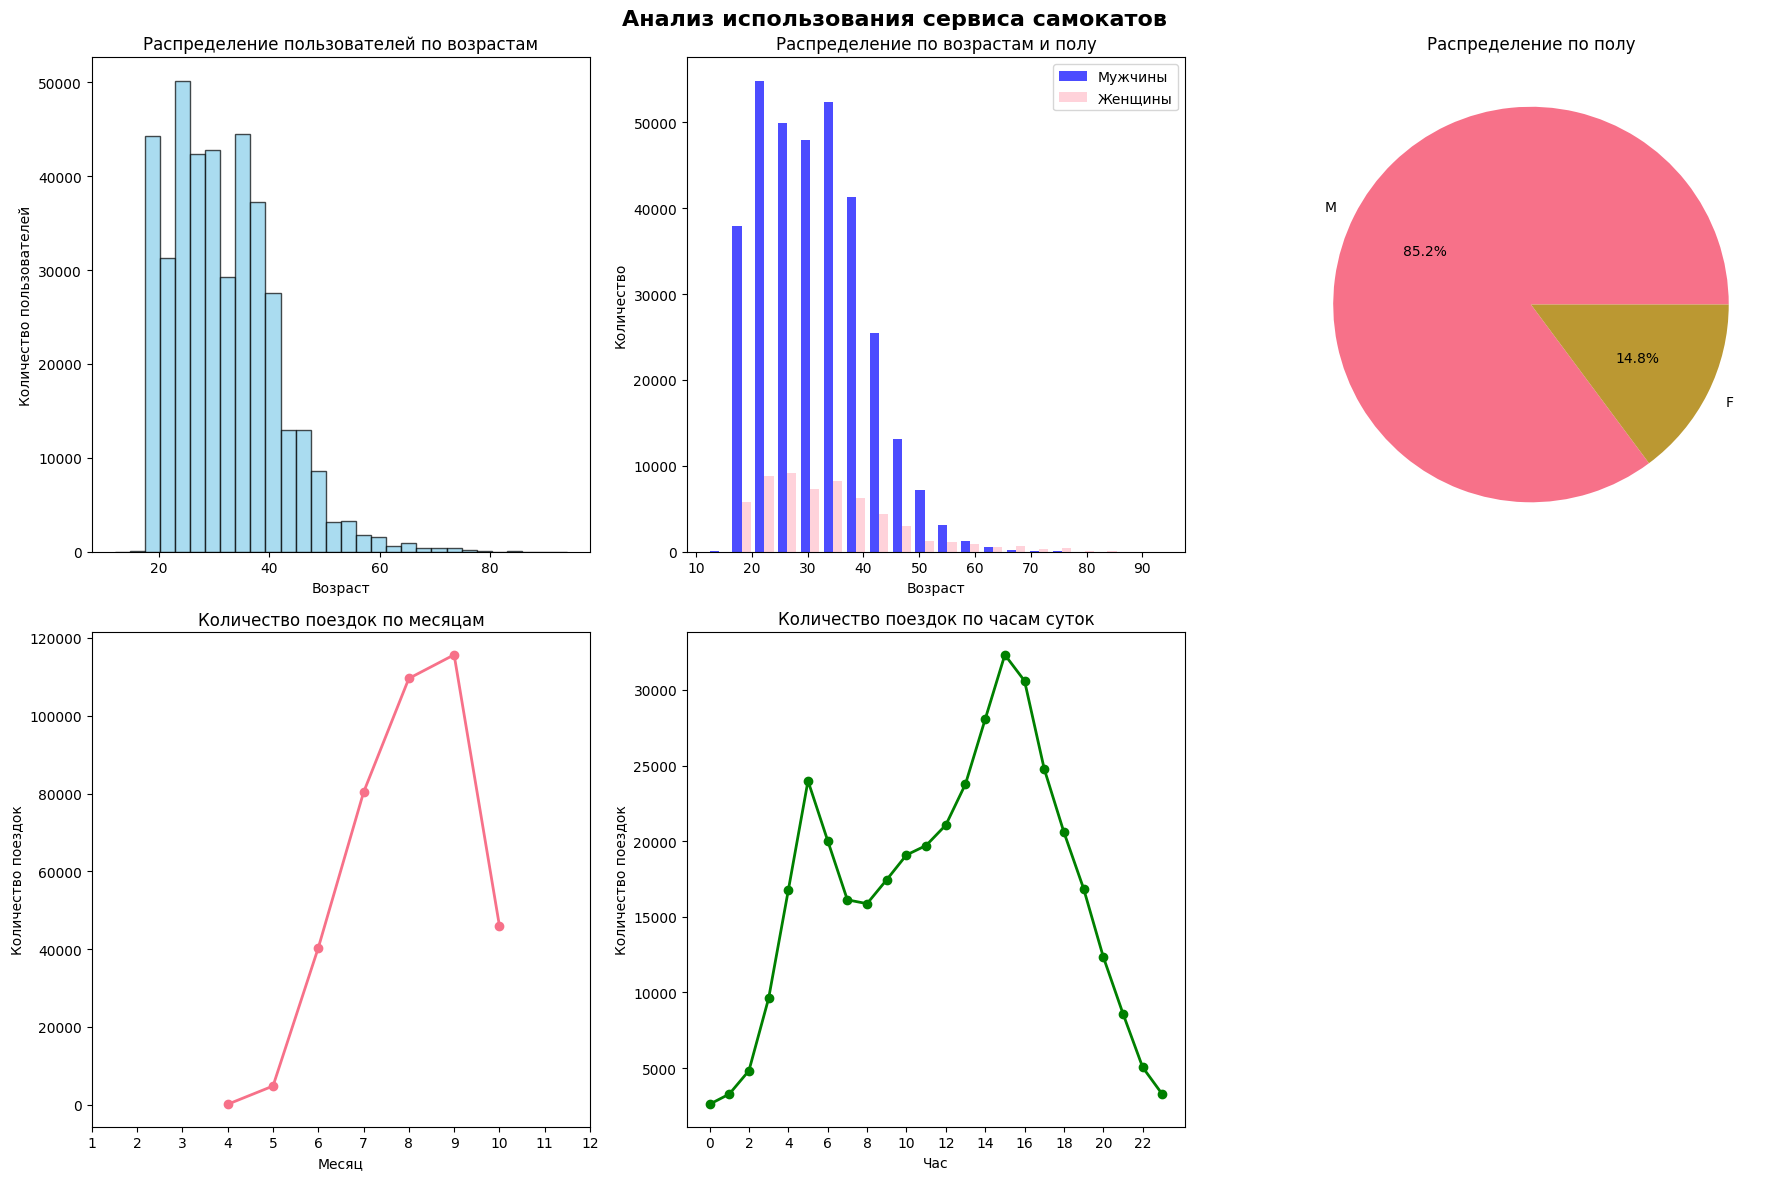


ДОПОЛНИТЕЛЬНАЯ СТАТИСТИКА
Средний возраст пользователей: 31.5 лет
Медианная длительность поездки: 7.8 минут
Медианное расстояние: 1.73 км

Распределение по полу:
  M: 335458 пользователей (84.6%)
  F: 58370 пользователей (14.7%)

Статистика по моделям самокатов:
                 distance_km  trip_duration_min
transport_model                                
B1D                     1.76              17.79
E                       2.50              11.15
ES                      2.77              18.78
ES-08S                  2.23              17.07
ES100                  16.01              15.54
ES200                   2.05              13.26
ES400                   5.65              14.34
LB                      1.96              12.32
Lucky                   0.02              12.19
MK                      2.35              15.48
Max                     3.63              12.75
SL                      3.90              10.99
Techno                  1.77              12.46
Urban E-Bike    

In [ ]:
plt.style.use('default')
sns.set_palette("husl")

# Базовая информация о данных
print("Размер данных:", df.shape)
print("\nИнформация о типах данных:")
print(df.info())

# Преобразование дат
date_columns = ['created_dttm', 'book_start_dttm', 'book_end_dttm', 'local_book_start_dttm']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

df['trip_duration_min'] = (df['book_end_dttm'] - df['book_start_dttm']).dt.total_seconds() / 60

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Анализ использования сервиса самокатов', fontsize=16, fontweight='bold')

# 1. Распределение по возрастам (совместно и по полам)
axes[0, 0].hist(df['age'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Распределение пользователей по возрастам')
axes[0, 0].set_xlabel('Возраст')
axes[0, 0].set_ylabel('Количество пользователей')

# Распределение по возрастам и полу
if 'gender_cd' in df.columns:
    males = df[df['gender_cd'] == 'M']['age'].dropna()
    females = df[df['gender_cd'] == 'F']['age'].dropna()

    axes[0, 1].hist([males, females], bins=20, alpha=0.7,
                   label=['Мужчины', 'Женщины'], color=['blue', 'pink'])
    axes[0, 1].set_title('Распределение по возрастам и полу')
    axes[0, 1].set_xlabel('Возраст')
    axes[0, 1].set_ylabel('Количество')
    axes[0, 1].legend()

# 2. Распределение по гендерам
if 'gender_cd' in df.columns:
    gender_counts = df['gender_cd'].value_counts()
    axes[0, 2].pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%')
    axes[0, 2].set_title('Распределение по полу')

# 3. Сезонные пики (по месяцам)
df['month'] = df['book_start_dttm'].dt.month
monthly_rides = df['month'].value_counts().sort_index()
axes[1, 0].plot(monthly_rides.index, monthly_rides.values, marker='o', linewidth=2)
axes[1, 0].set_title('Количество поездок по месяцам')
axes[1, 0].set_xlabel('Месяц')
axes[1, 0].set_ylabel('Количество поездок')
axes[1, 0].set_xticks(range(1, 13))

# Временные пики (по часам)
df['hour'] = df['book_start_dttm'].dt.hour
hourly_rides = df['hour'].value_counts().sort_index()
axes[1, 1].plot(hourly_rides.index, hourly_rides.values, marker='o', linewidth=2, color='green')
axes[1, 1].set_title('Количество поездок по часам суток')
axes[1, 1].set_xlabel('Час')
axes[1, 1].set_ylabel('Количество поездок')
axes[1, 1].set_xticks(range(0, 24, 2))

# Скрываем последний график
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

# Дополнительная статистика
print("\n" + "="*60)
print("ДОПОЛНИТЕЛЬНАЯ СТАТИСТИКА")
print("="*60)

print(f"Средний возраст пользователей: {df['age'].mean():.1f} лет")
print(f"Медианная длительность поездки: {df['trip_duration_min'].median():.1f} минут")
print(f"Медианное расстояние: {df['distance_km'].median():.2f} км")

if 'gender_cd' in df.columns:
    print(f"\nРаспределение по полу:")
    for gender, count in gender_counts.items():
        percentage = (count / len(df)) * 100
        print(f"  {gender}: {count} пользователей ({percentage:.1f}%)")

# Анализ по моделям самокатов
if 'transport_model' in df.columns:
    model_stats = df.groupby('transport_model').agg({
        'distance_km': 'mean',
        'trip_duration_min': 'mean'
    }).round(2)

    print(f"\nСтатистика по моделям самокатов:")
    print(model_stats)

##Графики распределения поездок

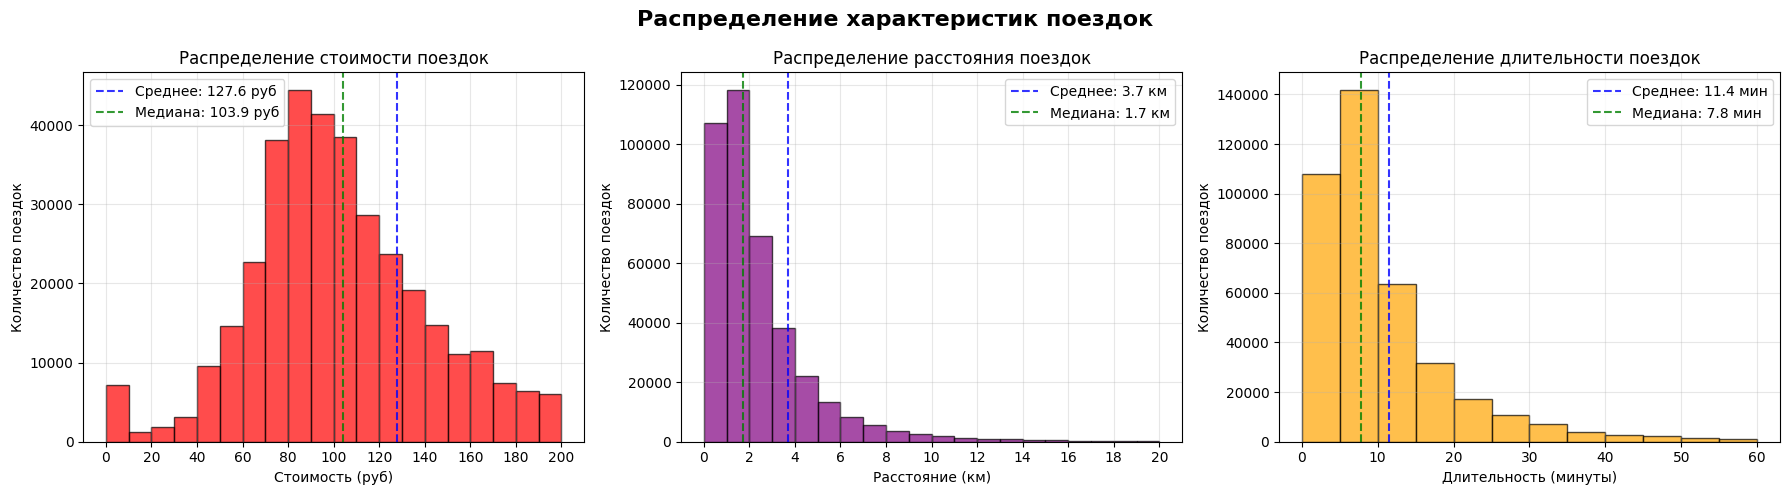


ГРАФИКИ С БОЛЬШИМ ДИАПАЗОНОМ ДЛЯ АНАЛИЗА ВЫБРОСОВ


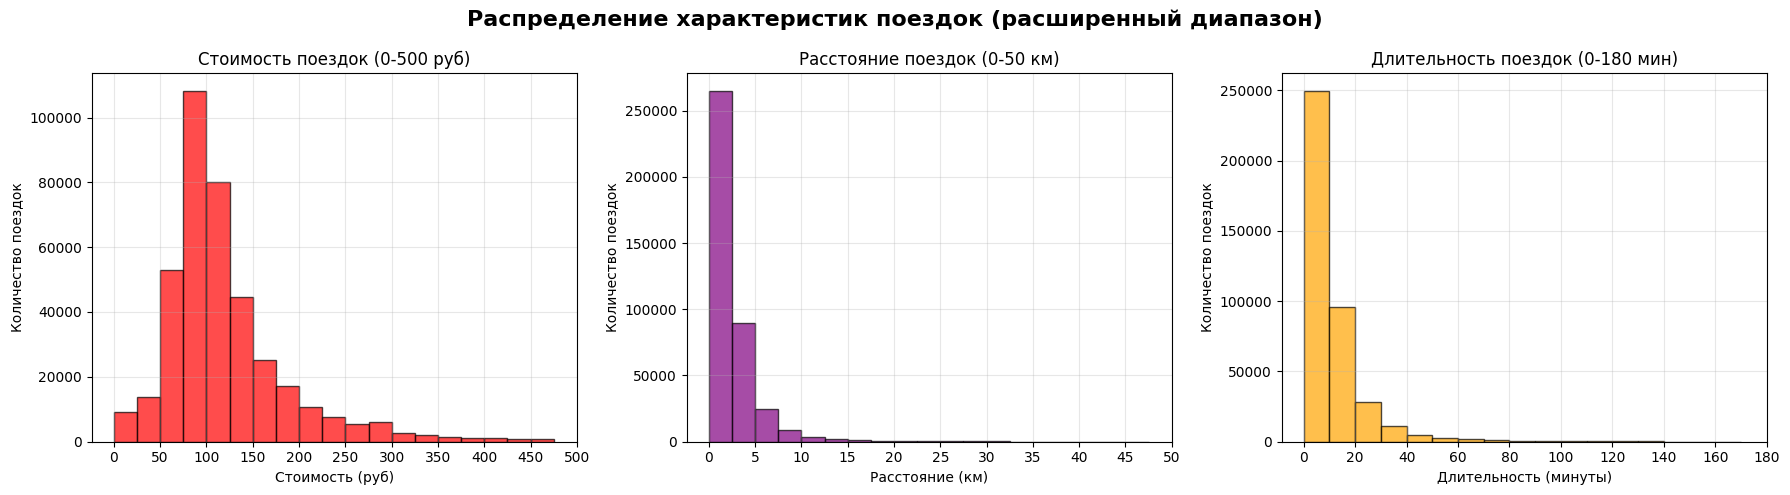


СТАТИСТИЧЕСКАЯ СВОДКА
СТОИМОСТЬ:
  Средняя: 127.65 руб
  Медиана: 103.94 руб
  Стандартное отклонение: 100.12 руб

РАССТОЯНИЕ:
  Среднее: 3.68 км
  Медиана: 1.73 км
  Стандартное отклонение: 141.86 км

ДЛИТЕЛЬНОСТЬ:
  Средняя: 11.44 мин
  Медиана: 7.77 мин
  Стандартное отклонение: 13.17 мин

КВАРТИЛИ:
Стоимость (25%, 50%, 75%): [ 80.84 103.94 142.1 ]
Расстояние (25%, 50%, 75%): [0.94105368 1.72988329 3.06369441]
Длительность (25%, 50%, 75%): [ 4.76305698  7.7686503  13.37104028]


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Настройка стиля
plt.style.use('default')
sns.set_palette("husl")

# Создаем отдельные графики с улучшенным масштабом
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Распределение характеристик поездок', fontsize=16, fontweight='bold')

# 1. Распределение стоимости поездки
cost_data = df['nominal_price_rub_amt'].dropna()
max_cost = min(cost_data.max(), 200)  # Ограничиваем до 200 руб для лучшего отображения
bins_cost = np.arange(0, max_cost + 10, 10)  # Бины с шагом 10

axes[0].hist(cost_data, bins=bins_cost, alpha=0.7, color='red', edgecolor='black')
axes[0].set_title('Распределение стоимости поездок')
axes[0].set_xlabel('Стоимость (руб)')
axes[0].set_ylabel('Количество поездок')
axes[0].set_xticks(bins_cost[::2])  # Каждая вторая метка для читаемости
axes[0].grid(True, alpha=0.3)

# Добавляем статистику на график стоимости
mean_cost = cost_data.mean()
median_cost = cost_data.median()
axes[0].axvline(mean_cost, color='blue', linestyle='--', alpha=0.8, label=f'Среднее: {mean_cost:.1f} руб')
axes[0].axvline(median_cost, color='green', linestyle='--', alpha=0.8, label=f'Медиана: {median_cost:.1f} руб')
axes[0].legend()

# 2. Распределение расстояния
distance_data = df['distance_km'].dropna()
max_distance = min(distance_data.max(), 20)  # Ограничиваем до 20 км для лучшего отображения
bins_distance = np.arange(0, max_distance + 1, 1)  # Бины с шагом 1 км

axes[1].hist(distance_data, bins=bins_distance, alpha=0.7, color='purple', edgecolor='black')
axes[1].set_title('Распределение расстояния поездок')
axes[1].set_xlabel('Расстояние (км)')
axes[1].set_ylabel('Количество поездок')
axes[1].set_xticks(np.arange(0, max_distance + 1, 2))  # Метки каждые 2 км
axes[1].grid(True, alpha=0.3)

# Добавляем статистику на график расстояния
mean_distance = distance_data.mean()
median_distance = distance_data.median()
axes[1].axvline(mean_distance, color='blue', linestyle='--', alpha=0.8, label=f'Среднее: {mean_distance:.1f} км')
axes[1].axvline(median_distance, color='green', linestyle='--', alpha=0.8, label=f'Медиана: {median_distance:.1f} км')
axes[1].legend()

# 3. Распределение длительности поездки
duration_data = df['trip_duration_min'].dropna()
max_duration = min(duration_data.max(), 60)  # Ограничиваем до 60 минут для лучшего отображения
bins_duration = np.arange(0, max_duration + 5, 5)  # Бины с шагом 5 минут

axes[2].hist(duration_data, bins=bins_duration, alpha=0.7, color='orange', edgecolor='black')
axes[2].set_title('Распределение длительности поездок')
axes[2].set_xlabel('Длительность (минуты)')
axes[2].set_ylabel('Количество поездок')
axes[2].set_xticks(np.arange(0, max_duration + 1, 10))  # Метки каждые 10 минут
axes[2].grid(True, alpha=0.3)

# Добавляем статистику на график длительности
mean_duration = duration_data.mean()
median_duration = duration_data.median()
axes[2].axvline(mean_duration, color='blue', linestyle='--', alpha=0.8, label=f'Среднее: {mean_duration:.1f} мин')
axes[2].axvline(median_duration, color='green', linestyle='--', alpha=0.8, label=f'Медиана: {median_duration:.1f} мин')
axes[2].legend()

plt.tight_layout()
plt.show()

# Дополнительные графики с другим масштабом для анализа выбросов
print("\n" + "="*60)
print("ГРАФИКИ С БОЛЬШИМ ДИАПАЗОНОМ ДЛЯ АНАЛИЗА ВЫБРОСОВ")
print("="*60)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Распределение характеристик поездок (расширенный диапазон)', fontsize=16, fontweight='bold')

# Стоимость - расширенный диапазон
bins_cost_extended = np.arange(0, 500, 25)  # Шаг 25 руб до 500 руб
axes[0].hist(cost_data, bins=bins_cost_extended, alpha=0.7, color='red', edgecolor='black')
axes[0].set_title('Стоимость поездок (0-500 руб)')
axes[0].set_xlabel('Стоимость (руб)')
axes[0].set_ylabel('Количество поездок')
axes[0].set_xticks(np.arange(0, 501, 50))
axes[0].grid(True, alpha=0.3)

# Расстояние - расширенный диапазон
bins_distance_extended = np.arange(0, 50, 2.5)  # Шаг 2.5 км до 50 км
axes[1].hist(distance_data, bins=bins_distance_extended, alpha=0.7, color='purple', edgecolor='black')
axes[1].set_title('Расстояние поездок (0-50 км)')
axes[1].set_xlabel('Расстояние (км)')
axes[1].set_ylabel('Количество поездок')
axes[1].set_xticks(np.arange(0, 51, 5))
axes[1].grid(True, alpha=0.3)

# Длительность - расширенный диапазон
bins_duration_extended = np.arange(0, 180, 10)  # Шаг 10 минут до 180 минут
axes[2].hist(duration_data, bins=bins_duration_extended, alpha=0.7, color='orange', edgecolor='black')
axes[2].set_title('Длительность поездок (0-180 мин)')
axes[2].set_xlabel('Длительность (минуты)')
axes[2].set_ylabel('Количество поездок')
axes[2].set_xticks(np.arange(0, 181, 20))
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Статистическая сводка
print("\n" + "="*60)
print("СТАТИСТИЧЕСКАЯ СВОДКА")
print("="*60)

print(f"СТОИМОСТЬ:")
print(f"  Средняя: {cost_data.mean():.2f} руб")
print(f"  Медиана: {cost_data.median():.2f} руб")
print(f"  Стандартное отклонение: {cost_data.std():.2f} руб")

print(f"\nРАССТОЯНИЕ:")
print(f"  Среднее: {distance_data.mean():.2f} км")
print(f"  Медиана: {distance_data.median():.2f} км")
print(f"  Стандартное отклонение: {distance_data.std():.2f} км")

print(f"\nДЛИТЕЛЬНОСТЬ:")
print(f"  Средняя: {duration_data.mean():.2f} мин")
print(f"  Медиана: {duration_data.median():.2f} мин")
print(f"  Стандартное отклонение: {duration_data.std():.2f} мин")

# Квартили для лучшего понимания распределения
print(f"\nКВАРТИЛИ:")
print(f"Стоимость (25%, 50%, 75%): {np.percentile(cost_data, [25, 50, 75])}")
print(f"Расстояние (25%, 50%, 75%): {np.percentile(distance_data, [25, 50, 75])}")
print(f"Длительность (25%, 50%, 75%): {np.percentile(duration_data, [25, 50, 75])}")

##Анализ уникальных пользователей

In [ ]:
n_unique_users = df['party_rk'].nunique()
n_total_orders = len(df)

print(f"Уникальные пользователи: {n_unique_users:,}")
print(f"Общее количество поездок: {n_total_orders:,}")
print(f"Отношение уникальных пользователей к общему числу поездок: {n_unique_users/n_total_orders:.2%}")
print(f"Среднее количество поездок на пользователя: {n_total_orders/n_unique_users:.2f}")

Уникальные пользователи: 64,052
Общее количество поездок: 396,749
Отношение уникальных пользователей к общему числу поездок: 16.14%
Среднее количество поездок на пользователя: 6.19


##Анализ траснпортных моделей

=== АНАЛИЗ МОДЕЛЕЙ САМОКАТОВ ===

1. Популярность моделей (топ-10):
transport_model
SL              241247
Max              70301
E                67666
Urban E-Bike      4704
ES400             4152
ES200             3325
ES100             2829
MK                1054
ES-08S             911
Techno             228
Name: count, dtype: int64


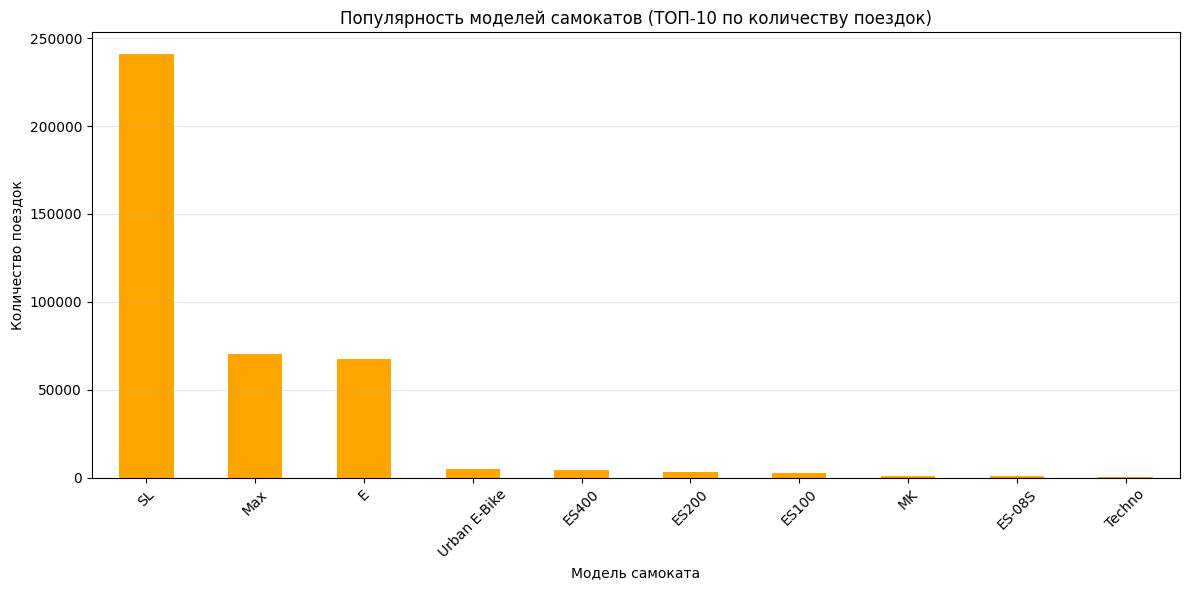


2. Стоимость за минуту по моделям (топ-10):
transport_model
B1D             18.47
Urban E-Bike    16.11
LB              15.82
SL              15.51
Techno          15.49
ES200           14.57
ES-08S          14.53
Max             13.36
E               12.99
MK              12.83
Name: cost_per_minute, dtype: float64


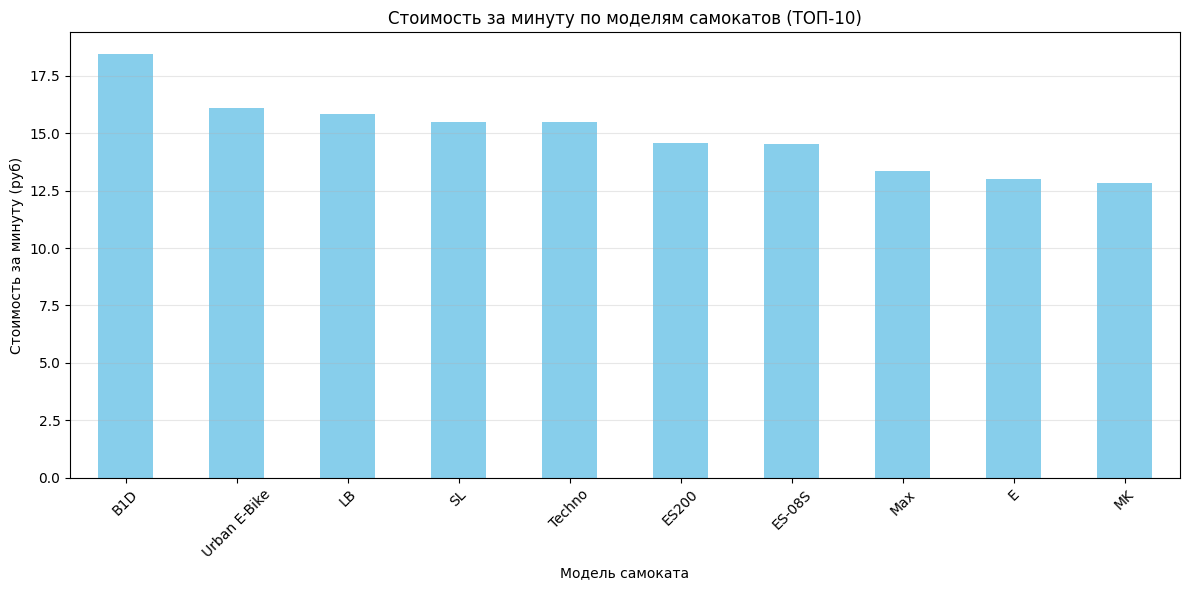


3. Анализ выгодности моделей (баланс стоимости и популярности):
Топ-10 самых выгодных моделей (баланс популярности и стоимости):
                 popularity  cost_per_minute  profitability_score
transport_model                                                  
SL                   241247            15.51                0.883
B1D                      36            18.47                0.500
Max                   70301            13.36                0.444
E                     67666            12.99                0.424
Urban E-Bike           4704            16.11                0.417
LB                      115            15.82                0.396
Techno                  228            15.49                0.383
ES200                  3325            14.57                0.353
ES-08S                  911            14.53                0.346
MK                     1054            12.83                0.280


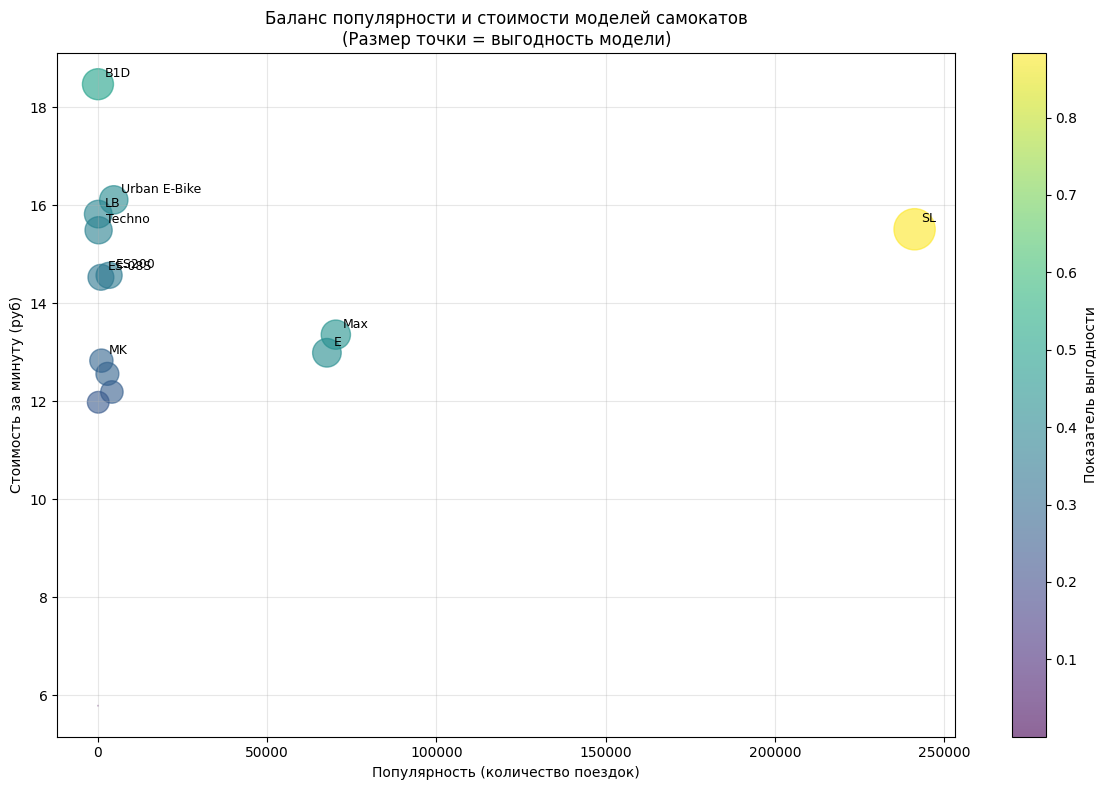


 ИНТЕРПРЕТАЦИЯ ГРАФИКА ВЫГОДНОСТИ:
 Правый верхний угол - популярные и дорогие модели (идеал)
 Правый нижний угол - популярные, но дешевые модели (массовый сегмент)
 Левый верхний угол - дорогие, но непопулярные модели (нишевые)
 Левый нижний угол - непопулярные и дешевые модели (невыгодные)

4. Гендерное распределение для топ-10 популярных моделей:
Топ-10 популярных моделей, отсортированных по проценту женщин:
gender_cd            F      M
transport_model              
Techno           24.56  75.44
ES-08S           19.48  80.52
E                14.94  85.06
SL               14.93  85.07
Max              14.72  85.28
ES100            14.30  85.70
ES400            13.77  86.23
ES200            13.07  86.93
MK               12.31  87.69
Urban E-Bike     10.75  89.25


<Figure size 1200x600 with 0 Axes>

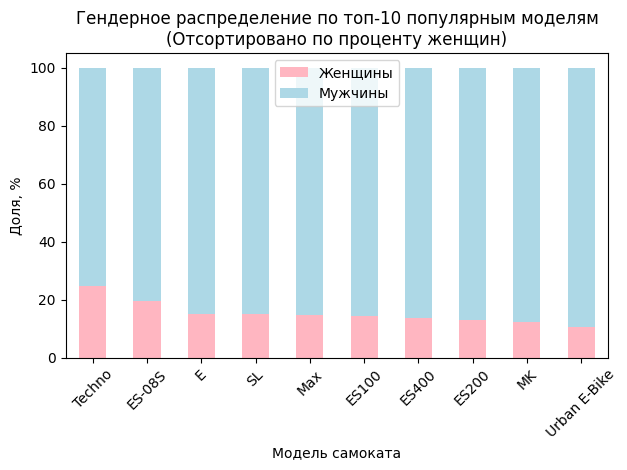


5. Модели с наибольшим средним возрастом пользователей:
Модели с наибольшим средним возрастом пользователей:
                  mean   count
transport_model               
LB               33.66     115
Techno           33.05     228
ES               32.12     119
Urban E-Bike     32.02    4704
SL               31.83  241247
Max              31.58   70301
MK               31.25    1054
ES-08S           31.09     911
ES200            30.64    3325
E                30.64   67666


<Figure size 1200x600 with 0 Axes>

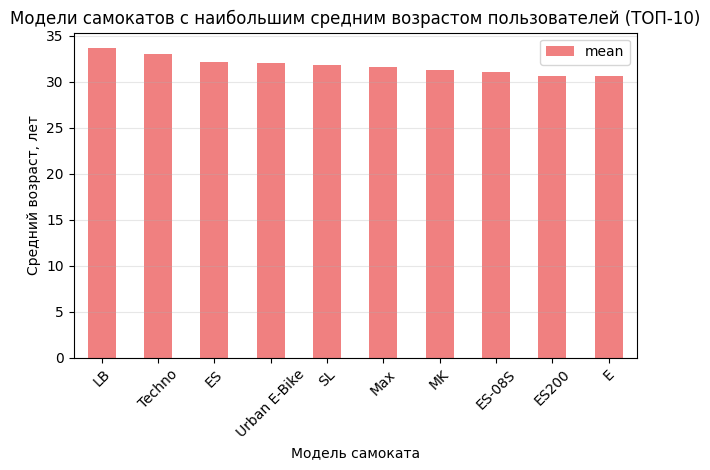


 КЛЮЧЕВЫЕ ВЫВОДЫ:
• Самые выгодные модели: SL, Max, E
• Модели с наибольшим процентом женщин: Techno, LB, Urban E-Bike
• Премиум-сегмент: B1D, Urban E-Bike, LB


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Расчет стоимости за минуту
df['cost_per_minute'] = df['nominal_price_rub_amt'] / df['trip_duration_min']

print("=== АНАЛИЗ МОДЕЛЕЙ САМОКАТОВ ===")

# 1. Популярность моделей (топ-10)
model_popularity = df['transport_model'].value_counts()
print("\n1. Популярность моделей (топ-10):")
print(model_popularity.head(10))

# График: Популярность моделей
plt.figure(figsize=(12, 6))
model_popularity.head(10).plot(kind='bar', color='orange')
plt.title('Популярность моделей самокатов (ТОП-10 по количеству поездок)')
plt.xlabel('Модель самоката')
plt.ylabel('Количество поездок')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Стоимость за минуту по моделям
cost_per_minute_analysis = df.groupby('transport_model')['cost_per_minute'].mean().round(2)
cost_per_minute_analysis = cost_per_minute_analysis.sort_values(ascending=False)

print("\n2. Стоимость за минуту по моделям (топ-10):")
print(cost_per_minute_analysis.head(10))

# График: Стоимость за минуту по моделям
plt.figure(figsize=(12, 6))
cost_per_minute_analysis.head(10).plot(kind='bar', color='skyblue')
plt.title('Стоимость за минуту по моделям самокатов (ТОП-10)')
plt.xlabel('Модель самоката')
plt.ylabel('Стоимость за минуту (руб)')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 3. График выгодности моделей (баланс стоимости и популярности)
print("\n3. Анализ выгодности моделей (баланс стоимости и популярности):")

# Создаем датафрейм для анализа
profitability_df = pd.DataFrame({
    'popularity': model_popularity,
    'cost_per_minute': cost_per_minute_analysis
}).dropna()

# Нормализуем показатели от 0 до 1 для сравнения
profitability_df['popularity_norm'] = (profitability_df['popularity'] - profitability_df['popularity'].min()) / (profitability_df['popularity'].max() - profitability_df['popularity'].min())
profitability_df['cost_norm'] = (profitability_df['cost_per_minute'] - profitability_df['cost_per_minute'].min()) / (profitability_df['cost_per_minute'].max() - profitability_df['cost_per_minute'].min())

# Создаем интегральный показатель выгодности (среднее между популярностью и стоимостью)
profitability_df['profitability_score'] = (profitability_df['popularity_norm'] + profitability_df['cost_norm']) / 2

# Сортируем по выгодности
profitability_df = profitability_df.sort_values('profitability_score', ascending=False)

print("Топ-10 самых выгодных моделей (баланс популярности и стоимости):")
print(profitability_df.head(10)[['popularity', 'cost_per_minute', 'profitability_score']].round(3))

# График: Баланс стоимости и популярности
plt.figure(figsize=(12, 8))

# Размер точек отражает интегральный показатель выгодности
sizes = profitability_df['profitability_score'] * 1000

scatter = plt.scatter(profitability_df['popularity'],
                     profitability_df['cost_per_minute'],
                     s=sizes, alpha=0.6, c=profitability_df['profitability_score'],
                     cmap='viridis')

# Добавляем подписи для топ-10 самых выгодных моделей
for i, model in enumerate(profitability_df.head(10).index):
    plt.annotate(model,
                (profitability_df.loc[model, 'popularity'],
                 profitability_df.loc[model, 'cost_per_minute']),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.colorbar(scatter, label='Показатель выгодности')
plt.title('Баланс популярности и стоимости моделей самокатов\n(Размер точки = выгодность модели)')
plt.xlabel('Популярность (количество поездок)')
plt.ylabel('Стоимость за минуту (руб)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n ИНТЕРПРЕТАЦИЯ ГРАФИКА ВЫГОДНОСТИ:")
print(" Правый верхний угол - популярные и дорогие модели (идеал)")
print(" Правый нижний угол - популярные, но дешевые модели (массовый сегмент)")
print(" Левый верхний угол - дорогие, но непопулярные модели (нишевые)")
print(" Левый нижний угол - непопулярные и дешевые модели (невыгодные)")

# 4. Обновленный анализ гендерного распределения для топ-10 популярных моделей
print("\n4. Гендерное распределение для топ-10 популярных моделей:")

# Получаем топ-10 популярных моделей
top_10_popular_models = model_popularity.head(10).index

# Создаем таблицу гендерного распределения только для топ-10
gender_top_10 = pd.crosstab(df[df['transport_model'].isin(top_10_popular_models)]['transport_model'],
                           df[df['transport_model'].isin(top_10_popular_models)]['gender_cd'],
                           normalize='index') * 100

# Сортируем по проценту женщин по убыванию
gender_top_10_sorted = gender_top_10.sort_values('F', ascending=False)

print("Топ-10 популярных моделей, отсортированных по проценту женщин:")
print(gender_top_10_sorted.round(2))

# График: Гендерное распределение (отсортировано по проценту женщин)
plt.figure(figsize=(12, 6))
gender_top_10_sorted.plot(kind='bar', stacked=True, color=['lightpink', 'lightblue'])
plt.title('Гендерное распределение по топ-10 популярным моделям\n(Отсортировано по проценту женщин)')
plt.xlabel('Модель самоката')
plt.ylabel('Доля, %')
plt.legend(['Женщины', 'Мужчины'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5. Анализ возраста - модели с наибольшим средним возрастом
print("\n5. Модели с наибольшим средним возрастом пользователей:")

# Получаем данные о возрасте для всех моделей
age_by_model = df.groupby('transport_model')['age'].agg(['mean', 'count']).round(2)
age_by_model = age_by_model[age_by_model['count'] > 100]  # Фильтр по значимым моделям

# Сортируем по убыванию среднего возраста
age_by_model_sorted = age_by_model.sort_values('mean', ascending=False)

print("Модели с наибольшим средним возрастом пользователей:")
print(age_by_model_sorted.head(10))

# График: Модели с наибольшим средним возрастом
plt.figure(figsize=(12, 6))
age_by_model_sorted.head(10).plot(kind='bar', y='mean', color='lightcoral')
plt.title('Модели самокатов с наибольшим средним возрастом пользователей (ТОП-10)')
plt.xlabel('Модель самоката')
plt.ylabel('Средний возраст, лет')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n КЛЮЧЕВЫЕ ВЫВОДЫ:")
print("• Самые выгодные модели: SL, Max, E")
print("• Модели с наибольшим процентом женщин: Techno, LB, Urban E-Bike")
print("• Премиум-сегмент: B1D, Urban E-Bike, LB")

Кривая Парето: распределение выручки по пользователям


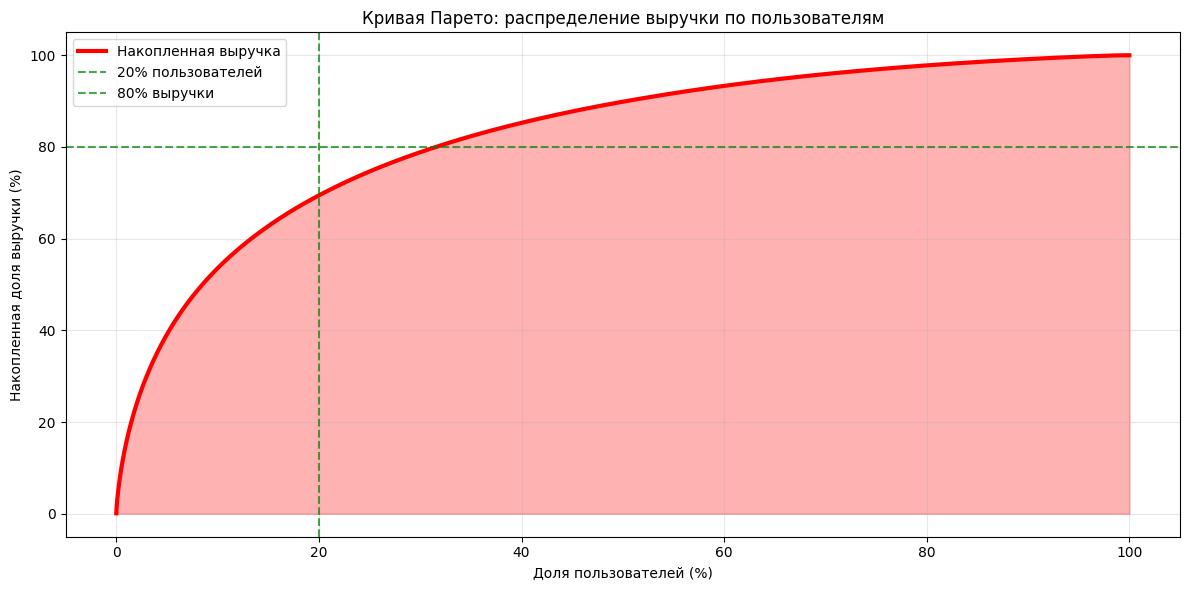

Конкретные показатели распределения Парето:
10% пользователей генерируют 53.6% выручки
20% пользователей генерируют 69.4% выручки
30% пользователей генерируют 78.9% выручки
50% пользователей генерируют 89.9% выручки
70% пользователей генерируют 95.9% выручки
80% пользователей генерируют 97.8% выручки
90% пользователей генерируют 99.2% выручки


In [ ]:
#кривая Парето
print("Кривая Парето: распределение выручки по пользователям")

# Группируем по пользователям и считаем общую выручку
user_revenue = df.groupby('party_rk')['nominal_price_rub_amt'].sum().sort_values(ascending=False)

# Рассчитываем накопленную долю выручки и пользователей
cumulative_revenue = user_revenue.cumsum()
total_revenue = user_revenue.sum()
cumulative_percentage_revenue = (cumulative_revenue / total_revenue) * 100

cumulative_users = np.arange(1, len(user_revenue) + 1)
cumulative_percentage_users = (cumulative_users / len(user_revenue)) * 100

# Упрощенный график Парето
plt.figure(figsize=(12, 6))
plt.plot(cumulative_percentage_users, cumulative_percentage_revenue, color='red', linewidth=3, label='Накопленная выручка')
plt.fill_between(cumulative_percentage_users, cumulative_percentage_revenue, alpha=0.3, color='red')

# Добавляем важные точки
plt.axvline(x=20, color='green', linestyle='--', alpha=0.7, label='20% пользователей')
plt.axhline(y=80, color='green', linestyle='--', alpha=0.7, label='80% выручки')

plt.xlabel('Доля пользователей (%)')
plt.ylabel('Накопленная доля выручки (%)')
plt.title('Кривая Парето: распределение выручки по пользователям')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Выводим конкретные цифры
print("Конкретные показатели распределения Парето:")
for percent in [10, 20, 30, 50, 70, 80, 90]:
    idx = int(len(user_revenue) * percent / 100)
    revenue_share = cumulative_percentage_revenue.iloc[idx] if idx < len(cumulative_percentage_revenue) else 100
    print(f"{percent}% пользователей генерируют {revenue_share:.1f}% выручки")

#Анализ социального статуса


Распределение по семейному статусу:
Холост/не замужем: 116094 пользователей (29.3%)
Женат/замужем: 74061 пользователей (18.7%)
Гражданский брак: 15036 пользователей (3.8%)
Разведен(а): 11820 пользователей (3.0%)
Вдовец/вдова: 718 пользователей (0.2%)


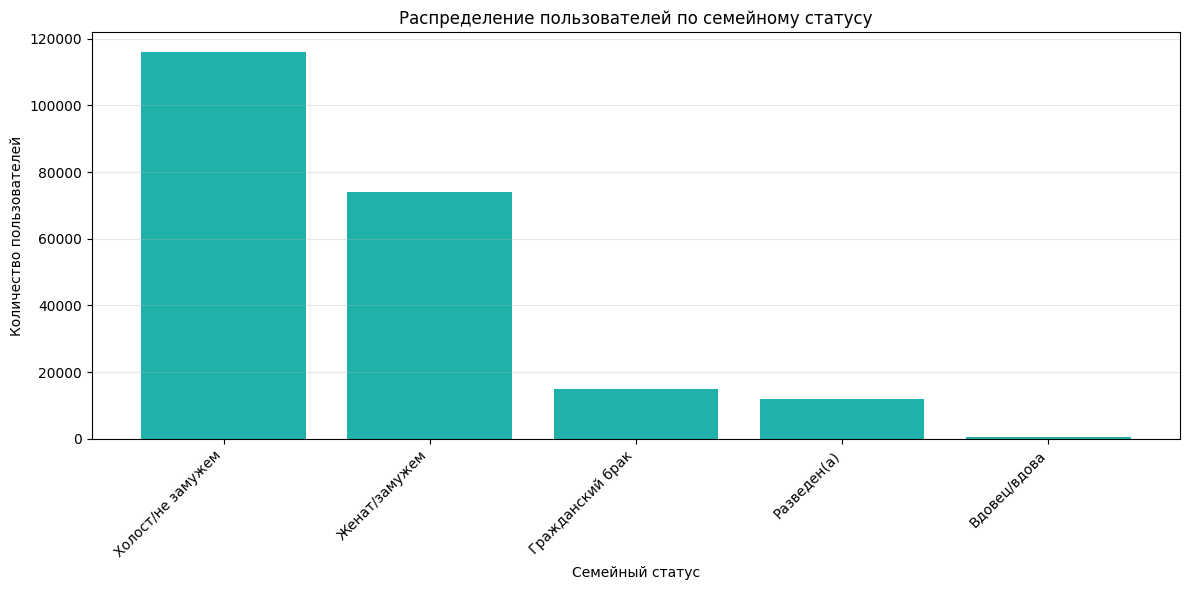


Средний возраст по семейному статусу:
                   mean  median   count
Вдовец/вдова       55.2    60.0     718
Разведен(а)        39.3    39.0   11820
Женат/замужем      36.9    36.0   74061
Гражданский брак   35.1    35.0   15036
Холост/не замужем  29.9    29.0  116094


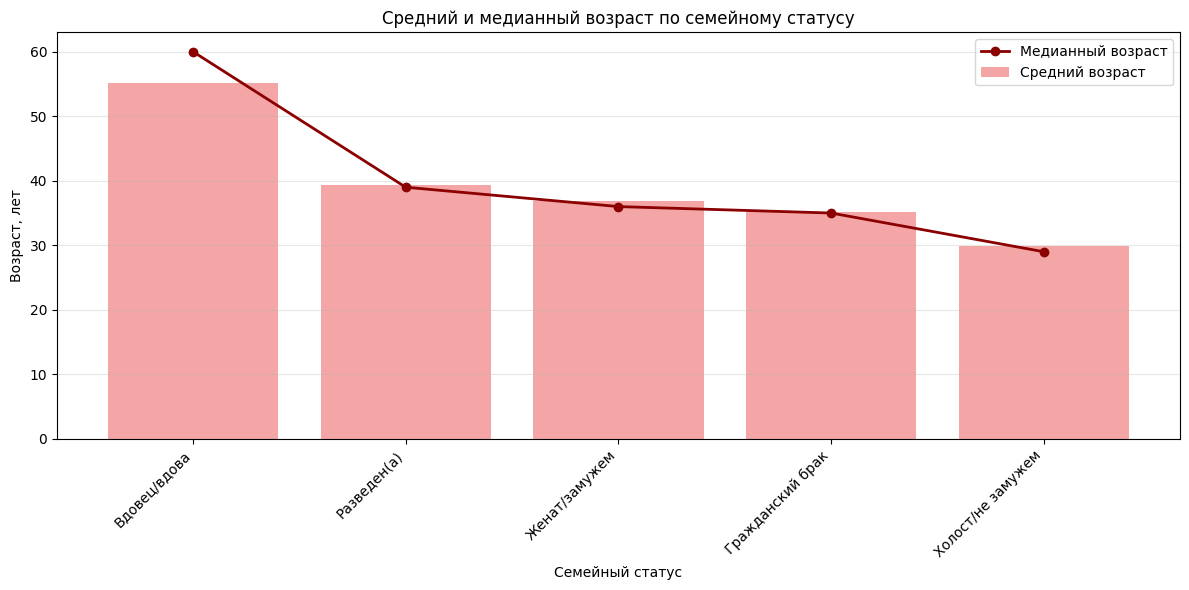


Самая популярная модель для каждого семейного статуса:
     Семейный статус Самая популярная модель  Количество поездок  \
0        Разведен(а)                      SL                6635   
1      Женат/замужем                      SL               43154   
2  Холост/не замужем                      SL               70193   
3   Гражданский брак                      SL                8673   
4       Вдовец/вдова                       E                 281   

  Доля в статусе  
0          56.1%  
1          58.3%  
2          60.5%  
3          57.7%  
4          39.1%  


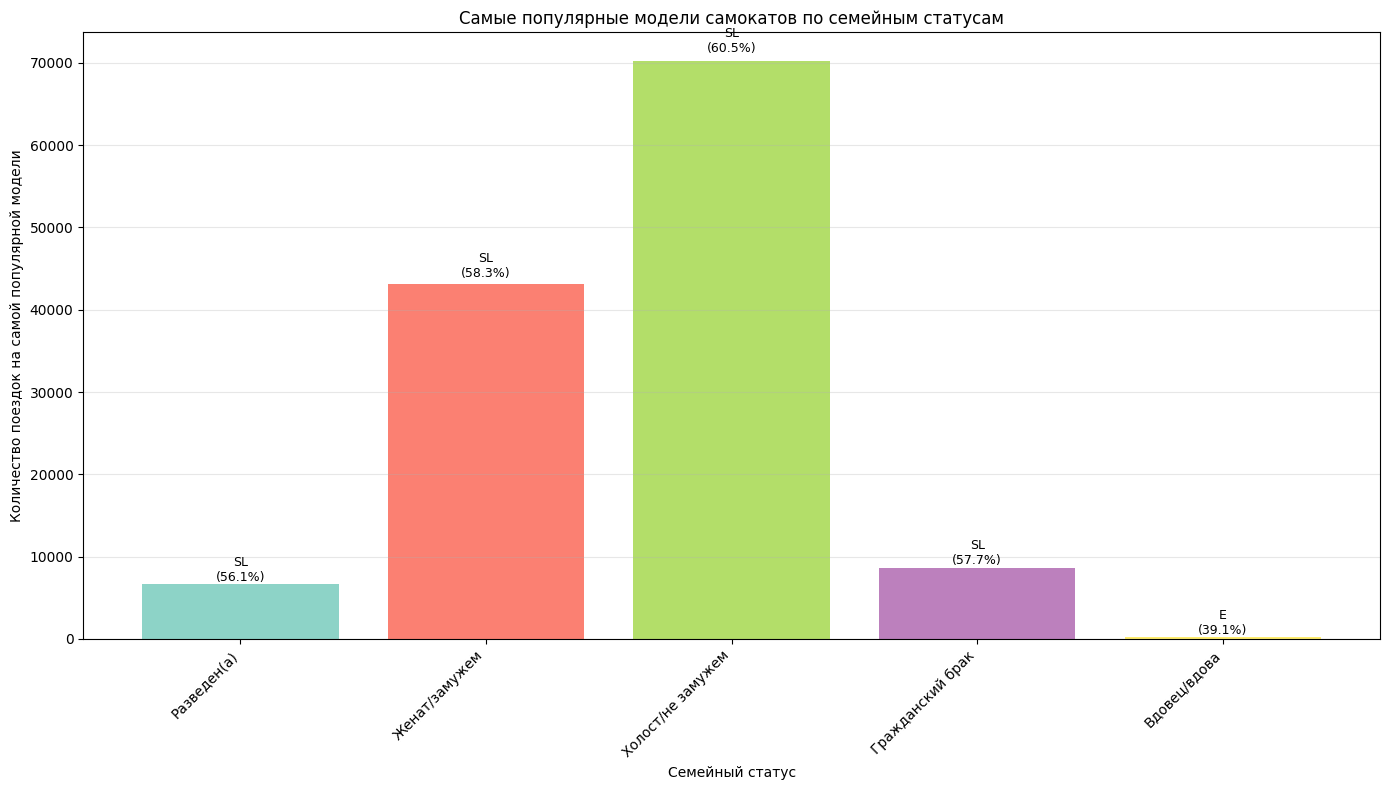


Средняя стоимость поездки по семейному статусу:
                     mean   count
Разведен(а)        135.29   11820
Вдовец/вдова       132.65     718
Женат/замужем      130.91   74061
Гражданский брак   128.51   15036
Холост/не замужем  126.00  116094


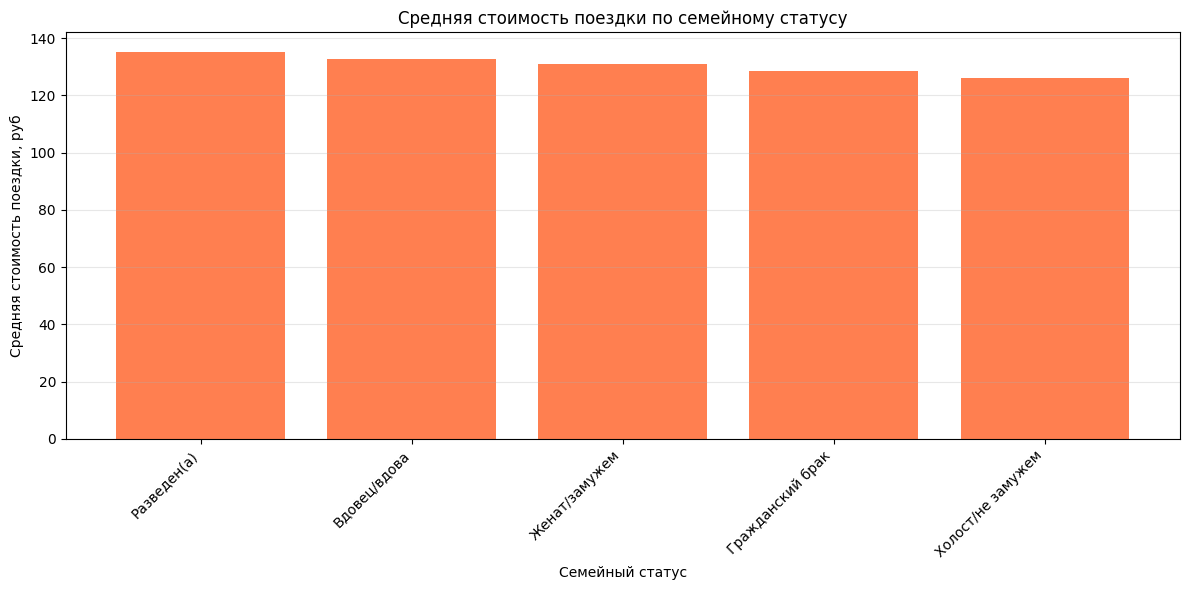


📊 ВЫВОДЫ ПО СЕМЕЙНОМУ СТАТУСУ:
• Наиболее распространенные статусы: холостые/не замужем, женатые/замужем
• Самый старший средний возраст: вдовцы/вдовы, разведенные
• Самая популярная модель для большинства статусов: SL
• Стоимость поездки варьируется в зависимости от семейного положения


In [ ]:
marital_status_dict = {
    'IMR': 'Незарегистрированный брак',
    'MAR': 'Женат/замужем',
    'DLW': 'Не проживает с супругом(ой)',
    'OMR': 'Зарегистрированный брак',
    'CIV': 'Гражданский брак',
    'UNM': 'Холост/не замужем',
    'DIV': 'Разведен(а)',
    'FAL': 'Никогда не состоял(а) в браке',
    'WID': 'Вдовец/вдова'
}

# Считаем распределение по статусам
marital_distribution = df['marital_status_cd'].value_counts()

print("\nРаспределение по семейному статусу:")
for status, count in marital_distribution.items():
    status_name = marital_status_dict.get(status, status)
    percentage = (count / len(df)) * 100
    print(f"{status_name}: {count} пользователей ({percentage:.1f}%)")

# График распределения по семейному статусу
plt.figure(figsize=(12, 6))
labels = [marital_status_dict.get(status, status) for status in marital_distribution.index]
plt.bar(labels, marital_distribution.values, color='lightseagreen')
plt.title('Распределение пользователей по семейному статусу')
plt.xlabel('Семейный статус')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Анализ среднего возраста по семейному статусу
print("\nСредний возраст по семейному статусу:")
marital_age = df.groupby('marital_status_cd')['age'].agg(['mean', 'median', 'count']).round(1)
marital_age = marital_age[marital_age['count'] > 100]  # Фильтруем по значимым группам

# Переименовываем индексы для читаемости
marital_age.index = [marital_status_dict.get(status, status) for status in marital_age.index]

print(marital_age.sort_values('mean', ascending=False))

# График: Средний возраст по семейному статусу
plt.figure(figsize=(12, 6))
marital_age_sorted = marital_age.sort_values('mean', ascending=False)
plt.bar(marital_age_sorted.index, marital_age_sorted['mean'], color='lightcoral', alpha=0.7, label='Средний возраст')
plt.plot(marital_age_sorted.index, marital_age_sorted['median'], marker='o', color='darkred', linewidth=2, label='Медианный возраст')
plt.title('Средний и медианный возраст по семейному статусу')
plt.xlabel('Семейный статус')
plt.ylabel('Возраст, лет')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Анализ самых популярных моделей для каждого семейного статуса
print("\nСамая популярная модель для каждого семейного статуса:")

# Для каждого статуса находим модель с максимальным количеством поездок
popular_models_by_status = {}

for status in df['marital_status_cd'].unique():
    status_data = df[df['marital_status_cd'] == status]
    if len(status_data) > 0:
        model_counts = status_data['transport_model'].value_counts()
        if len(model_counts) > 0:
            popular_model = model_counts.index[0]
            popular_models_by_status[status] = {
                'model': popular_model,
                'count': model_counts.iloc[0],
                'percentage': (model_counts.iloc[0] / len(status_data)) * 100
            }

# Создаем таблицу результатов
status_popular_models = []
for status, data in popular_models_by_status.items():
    status_name = marital_status_dict.get(status, status)
    status_popular_models.append({
        'Семейный статус': status_name,
        'Самая популярная модель': data['model'],
        'Количество поездок': data['count'],
        'Доля в статусе': f"{data['percentage']:.1f}%"
    })

popular_models_df = pd.DataFrame(status_popular_models)
print(popular_models_df)

# График: Самые популярные модели по семейным статусам
plt.figure(figsize=(14, 8))
models_data = popular_models_df.set_index('Семейный статус')
colors = plt.cm.Set3(np.linspace(0, 1, len(models_data)))

bars = plt.bar(models_data.index, models_data['Количество поездок'], color=colors)
plt.title('Самые популярные модели самокатов по семейным статусам')
plt.xlabel('Семейный статус')
plt.ylabel('Количество поездок на самой популярной модели')
plt.xticks(rotation=45, ha='right')

# Добавляем подписи с названиями моделей
for i, (bar, row) in enumerate(zip(bars, models_data.iterrows())):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f"{row[1]['Самая популярная модель']}\n({row[1]['Доля в статусе']})",
             ha='center', va='bottom', fontsize=9)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Дополнительный анализ: средняя стоимость поездки по семейному статусу
print("\nСредняя стоимость поездки по семейному статусу:")
marital_cost = df.groupby('marital_status_cd')['nominal_price_rub_amt'].agg(['mean', 'count']).round(2)
marital_cost = marital_cost[marital_cost['count'] > 100]  # Фильтруем по значимым группам

# Переименовываем индексы для читаемости
marital_cost.index = [marital_status_dict.get(status, status) for status in marital_cost.index]

print(marital_cost.sort_values('mean', ascending=False))

# График: Средняя стоимость поездки по семейному статусу
plt.figure(figsize=(12, 6))
marital_cost_sorted = marital_cost.sort_values('mean', ascending=False)
plt.bar(marital_cost_sorted.index, marital_cost_sorted['mean'], color='coral')
plt.title('Средняя стоимость поездки по семейному статусу')
plt.xlabel('Семейный статус')
plt.ylabel('Средняя стоимость поездки, руб')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nВЫВОДЫ")
print("• Наиболее распространенные статусы: холостые/не замужем, женатые/замужем")
print("• Самый старший средний возраст: вдовцы/вдовы, разведенные")
print("• Самая популярная модель для большинства статусов: SL")

##Распределение по городам

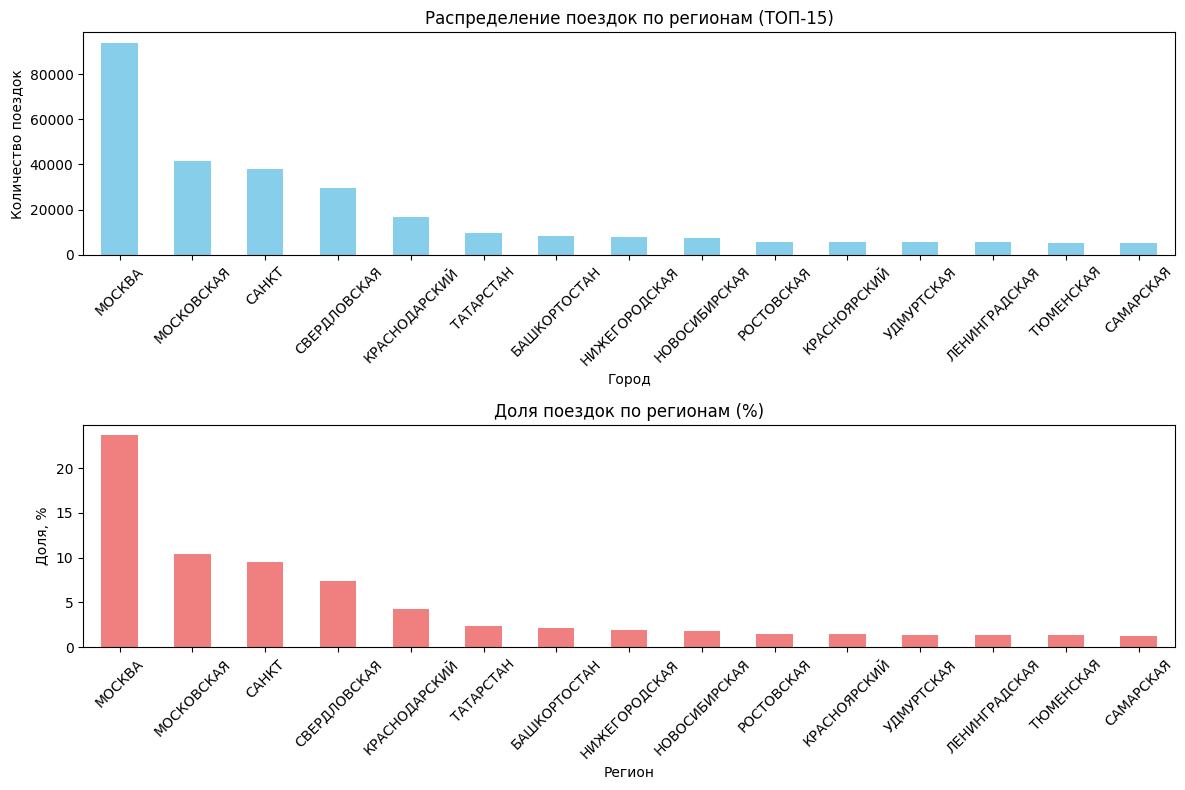

Топ-5 регионов по количеству поездок:
1. МОСКВА: 93773 поездок (23.64%)
2. МОСКОВСКАЯ: 41504 поездок (10.46%)
3. САНКТ: 37912 поездок (9.56%)
4. СВЕРДЛОВСКАЯ: 29434 поездок (7.42%)
5. КРАСНОДАРСКИЙ: 16738 поездок (4.22%)


In [ ]:
# Распределение поездок по городам
if 'lvn_state_nm_normalized' in df.columns:
    plt.figure(figsize=(12, 8))
    city_distribution = df['lvn_state_nm_normalized'].value_counts().head(15)

    plt.subplot(2,1,1)
    city_distribution.plot(kind='bar', color='skyblue')
    plt.title('Распределение поездок по регионам (ТОП-15)')
    plt.xlabel('Город')
    plt.ylabel('Количество поездок')
    plt.xticks(rotation=45)

    plt.subplot(2,1,2)
    # Доля от общего числа поездок
    city_share = (city_distribution / len(df) * 100).round(2)
    city_share.plot(kind='bar', color='lightcoral')
    plt.title('Доля поездок по регионам (%)')
    plt.xlabel('Регион')
    plt.ylabel('Доля, %')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    print(f"Топ-5 регионов по количеству поездок:")
    for i, (city, count) in enumerate(city_distribution.head().items(), 1):
        print(f"{i}. {city}: {count} поездок ({city_share[city]}%)")